# Fine amplitude calibration

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gates sequences apply a variable number of times the same gate. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with *ibmq_armonk* and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.calibration.fine_amplitude import FineAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.8031251817079895+0j), sigma=80, beta=-0.7400131120820395, name='Xp_d0')

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8031+0.0000j.


### Detect an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.01
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [7]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_over, angle_per_gate=target_angle, add_xp_circuit=True, add_sx = True)
amp_cal.set_experiment_options(add_sx=True)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

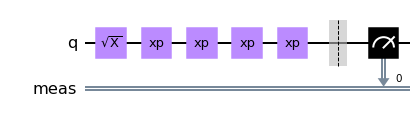

In [8]:
amp_cal.circuits(backend)[5].draw(output="mpl")

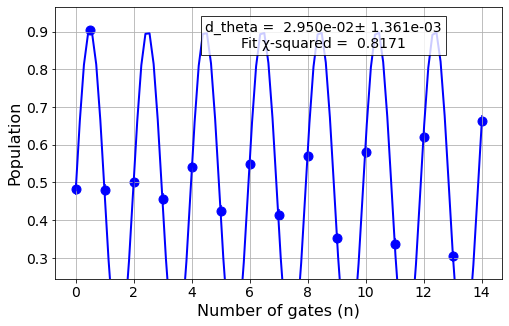

In [9]:
data_over = amp_cal.run(backend)

In [10]:
result = data_over.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.85212883,  0.02950285,  0.47940124]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01993587, 0.0013607 , 0.00394727]),
 'pcov': array([[3.97438768e-04, 1.39460440e-05, 3.12238880e-05],
        [1.39460440e-05, 1.85149563e-06, 9.56192993e-07],
        [3.12238880e-05, 9.56192993e-07, 1.55809230e-05]]),
 'reduced_chisq': 0.8171139829993732,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [11]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.030 rad.
Thus, scale the 0.8112+0.0000j pulse amplitude by 0.991 to obtain 0.80361+0.00000j.
Amplitude reported by the backend 0.8031+0.0000j.


### Detect an under-rotated pulse

In [12]:
pulse_amp = ideal_amp*0.99
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [13]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_under, angle_per_gate=target_angle, add_xp_circuit=True, add_sx=True)
amp_cal.set_experiment_options(add_sx=True)

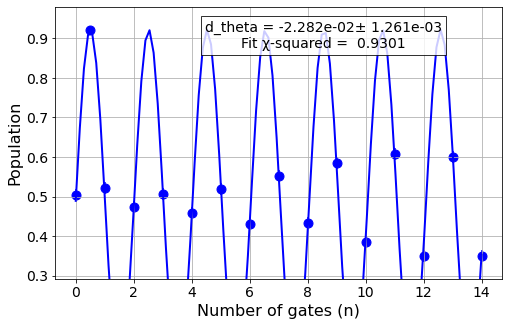

In [14]:
data_under = amp_cal.run(backend)

In [15]:
result = data_under.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.8652375 , -0.02281627,  0.48931429]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01856643, 0.00126123, 0.00398568]),
 'pcov': array([[ 3.44712377e-04, -9.91211085e-06,  3.17408765e-05],
        [-9.91211085e-06,  1.59070736e-06, -1.16814279e-06],
        [ 3.17408765e-05, -1.16814279e-06,  1.58856733e-05]]),
 'reduced_chisq': 0.9301156946006477,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [16]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.023 rad.
Thus, scale the 0.7951+0.0000j pulse amplitude by 1.007 to obtain 0.80091+0.00000j.
Amplitude reported by the backend 0.8031+0.0000j.


### Analyze a pi-half pulse

We now consider the pi-half rotation. Note that in this case we do not need to add a pi-half rotation to the circuits.

In [17]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [18]:
amp_cal.set_schedule(schedule=x90p, angle_per_gate=target_angle, add_xp_circuit=True, add_sx=False)

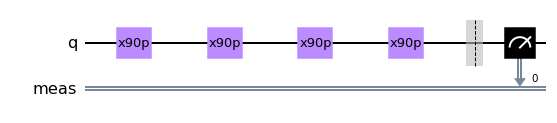

In [19]:
amp_cal.circuits(backend)[5].draw(output="mpl")

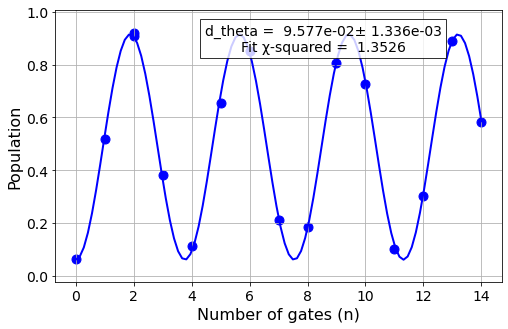

In [20]:
data_x90p = amp_cal.run(backend)

In [21]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.85440553,  0.09576886,  0.48754808]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.00672887, 0.00133626, 0.00277724]),
 'pcov': array([[4.52777148e-05, 4.37528863e-07, 9.12501081e-07],
        [4.37528863e-07, 1.78559895e-06, 1.86356370e-07],
        [9.12501081e-07, 1.86356370e-07, 7.71308670e-06]]),
 'reduced_chisq': 1.3526433246562009,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [22]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.096 rad.
Thus, scale the 0.4016+0.0000j pulse amplitude by 0.943 to obtain 0.37849+0.00000j.
Amplitude reported by the backend 0.3696-0.0760j.


Let's rerun this calibration using the updated value of the amplitude of the pi-half pulse and run under slightly different settings. We will run only points on the equator of the Bloch sphere except for the first three pi-half pulses.

In [23]:
pulse_amp = ideal_amp / 2 * scale
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [24]:
repetitions = [1, 2, 3] + list(range(5,21,2))
amp_cal.set_schedule(schedule=x90p, angle_per_gate=target_angle, add_xp_circuit=False, add_sx=False)
amp_cal.set_experiment_options(repetitions=repetitions)

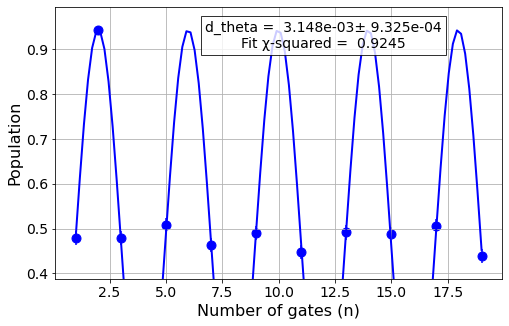

In [25]:
data_x90p = amp_cal.run(backend)

In [26]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.92609195,  0.00314819,  0.48032259]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01751531, 0.00093248, 0.00495221]),
 'pcov': array([[3.06785957e-04, 1.86171859e-06, 4.90427579e-05],
        [1.86171859e-06, 8.69518413e-07, 5.80873999e-07],
        [4.90427579e-05, 5.80873999e-07, 2.45243671e-05]]),
 'reduced_chisq': 0.9244848695464735,
 'dof': 8,
 'xrange': [1.0, 19.0],
 'quality': 'computer_good',
 'success': True}

In [27]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.003 rad.
Thus, scale the 0.3785+0.0000j pulse amplitude by 0.998 to obtain 0.37773+0.00000j.
Amplitude reported by the backend 0.3696-0.0760j.
